# Flight Booking Classification Model

## Installing the necessary libraries

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import AutoTokenizer, AutoModel
import torch

# Load InLegalBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")
model = AutoModel.from_pretrained("law-ai/InLegalBERT")
model.eval()  # Set to evaluation mode

print("loading done")
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader



# Miscellaneous
import warnings
warnings.filterwarnings('ignore')
import shap

tokenizer_config.json:   0%|          | 0.00/516 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/534M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


loading done


model.safetensors:   0%|          | 0.00/534M [00:00<?, ?B/s]

In [3]:
print(transformers.__version__)
from transformers.optimization import AdamW
#ADAM NOT WORKING???

!nvidia-smi



4.48.0
Wed Jul 23 00:50:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:E1:00.0 Off |                  Off |
| 30%   28C    P8             25W /  300W |       5MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------------------

In [4]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
plt.rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install seaborn

## An overview of the data

In [4]:
!pip install -U gdown
import gdown

# Download the file directly using its ID
file_id = "1oebyD14zyAq8QjeK8PSeRg_2R6ekSu6u"
gdown.download(id=file_id, output="24k_cleaned.csv", quiet=False)

# Load the CSV
import pandas as pd
df = pd.read_csv("24k_cleaned.csv")

# Check
print("Shape:", df.shape)
print(df.head())



Downloading...
From (original): https://drive.google.com/uc?id=1oebyD14zyAq8QjeK8PSeRg_2R6ekSu6u
From (redirected): https://drive.google.com/uc?id=1oebyD14zyAq8QjeK8PSeRg_2R6ekSu6u&confirm=t&uuid=cff30a80-3a02-47e9-8fa2-afd43291a72a
To: c:\adeng\research\ljp-interp\24k_cleaned.csv
100%|██████████| 294M/294M [00:37<00:00, 7.87MB/s] 


Shape: (24128, 4)
                                                text  label  split  \
0   M. JOSEPH, J. The appeal is directed against ...      0  train   
1   M. Khanwilkar, J. Delay companydoned. Leave g...      1  train   
2   HEMANT GUPTA, J. The challenge in the present...      0  train   
3   INDU MALHOTRA, J. Leave granted. The issue wh...      0  train   
4   Dr Dhananjaya Y Chandrachud, J 1 This appeal ...      0  train   

          name  
0  2020_10.txt  
1  2020_12.txt  
2  2020_14.txt  
3  2020_15.txt  
4  2020_20.txt  


<Axes: xlabel='label', ylabel='count'>

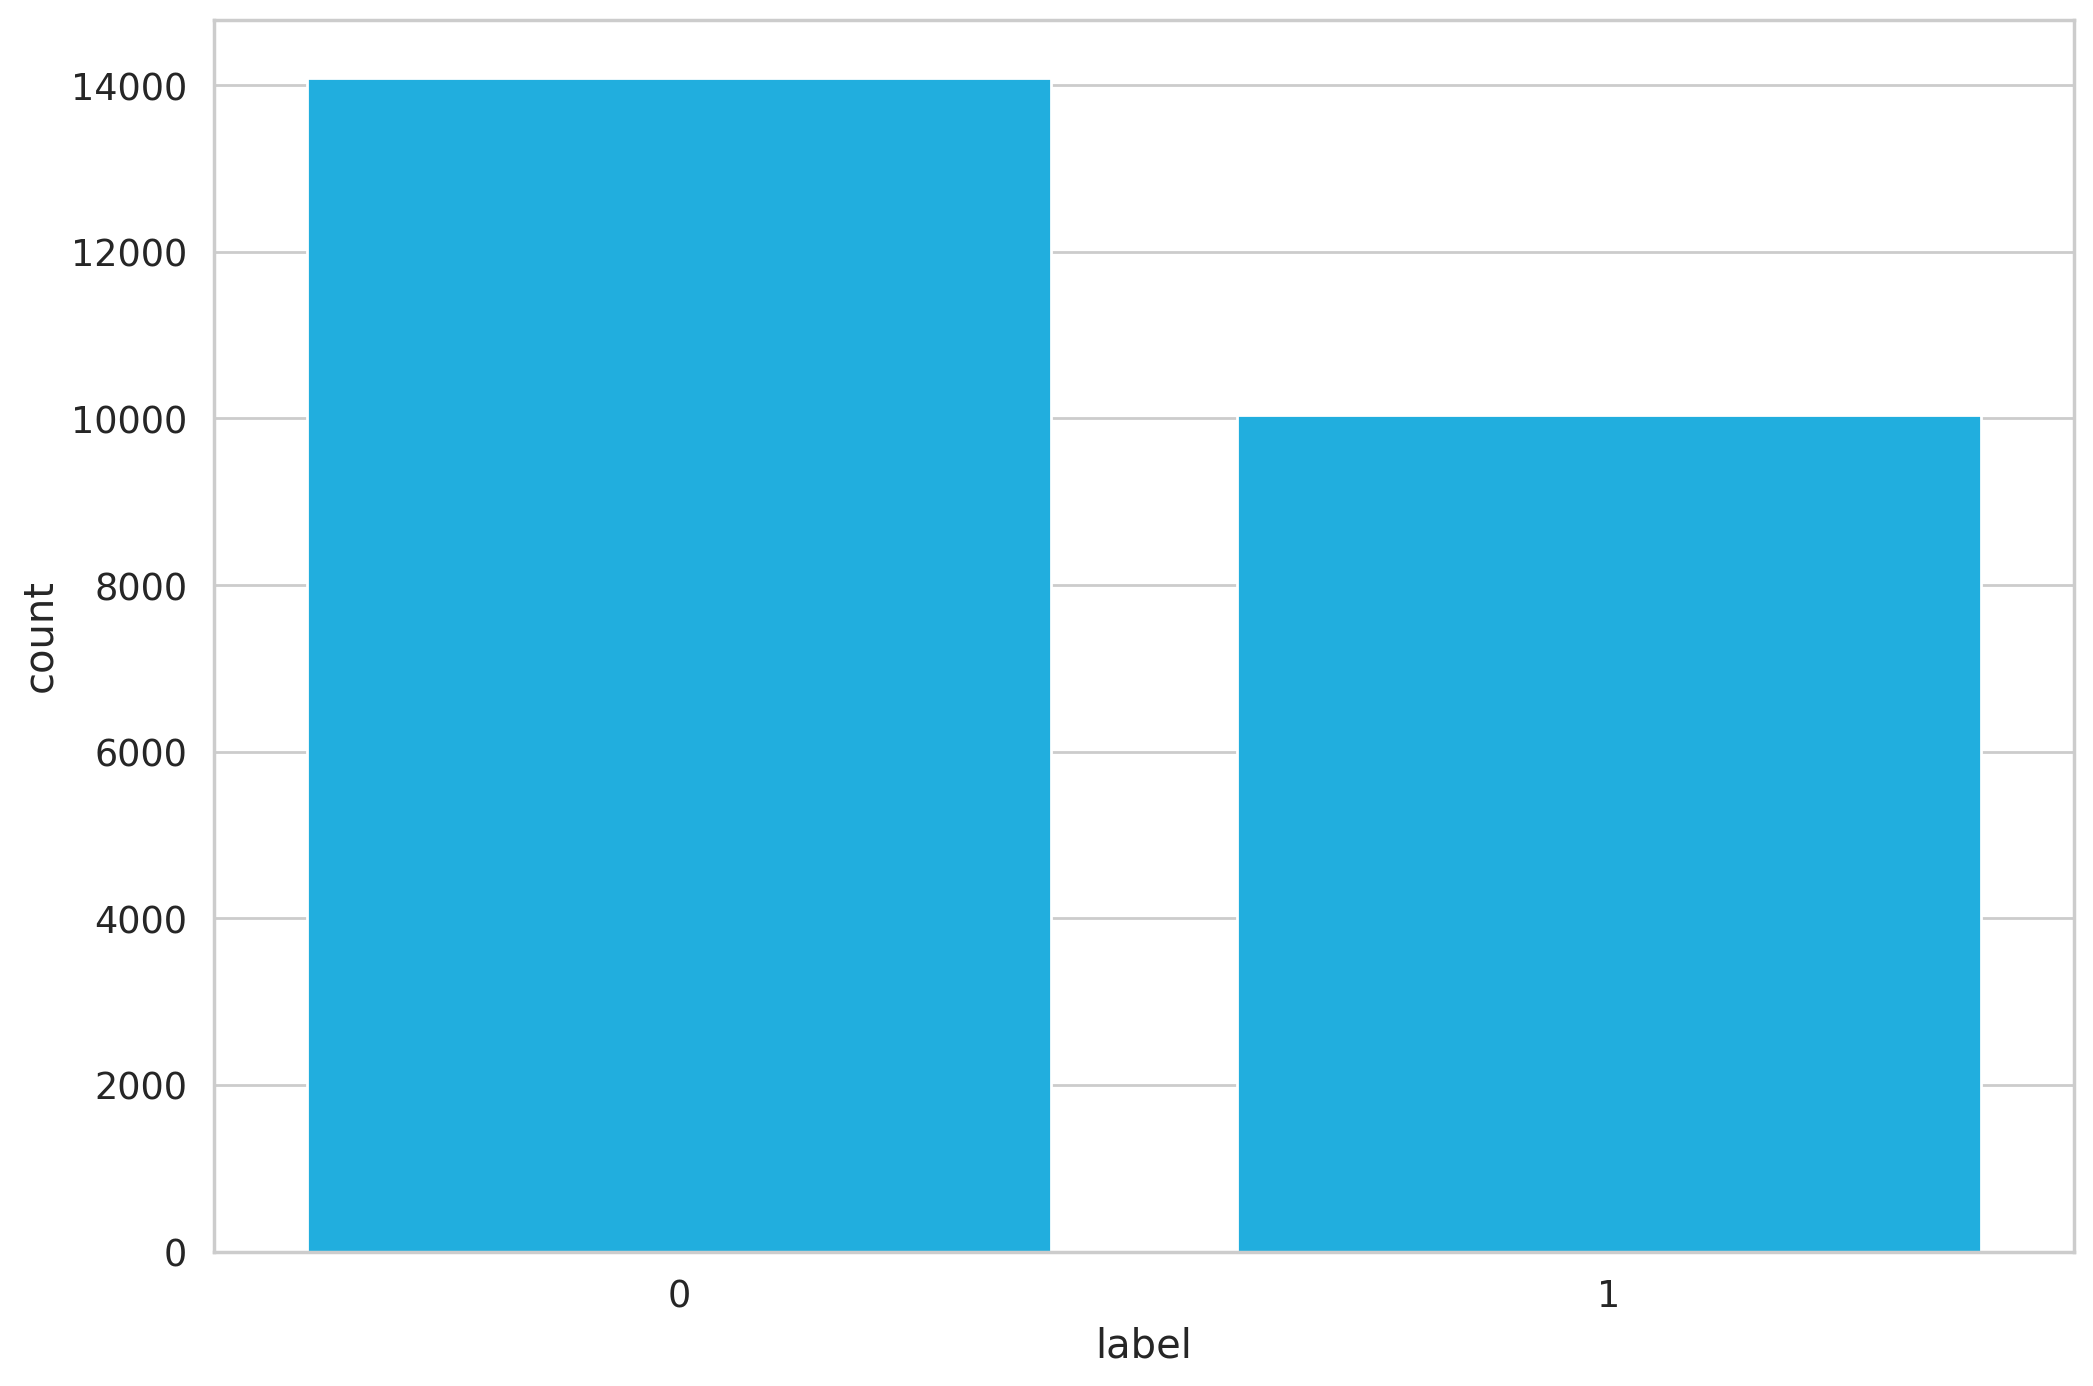

In [6]:
import seaborn as sns
sns.countplot(df, x="label")


## Setting up the Model

In [7]:
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


## Tokenizing

In [8]:
# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

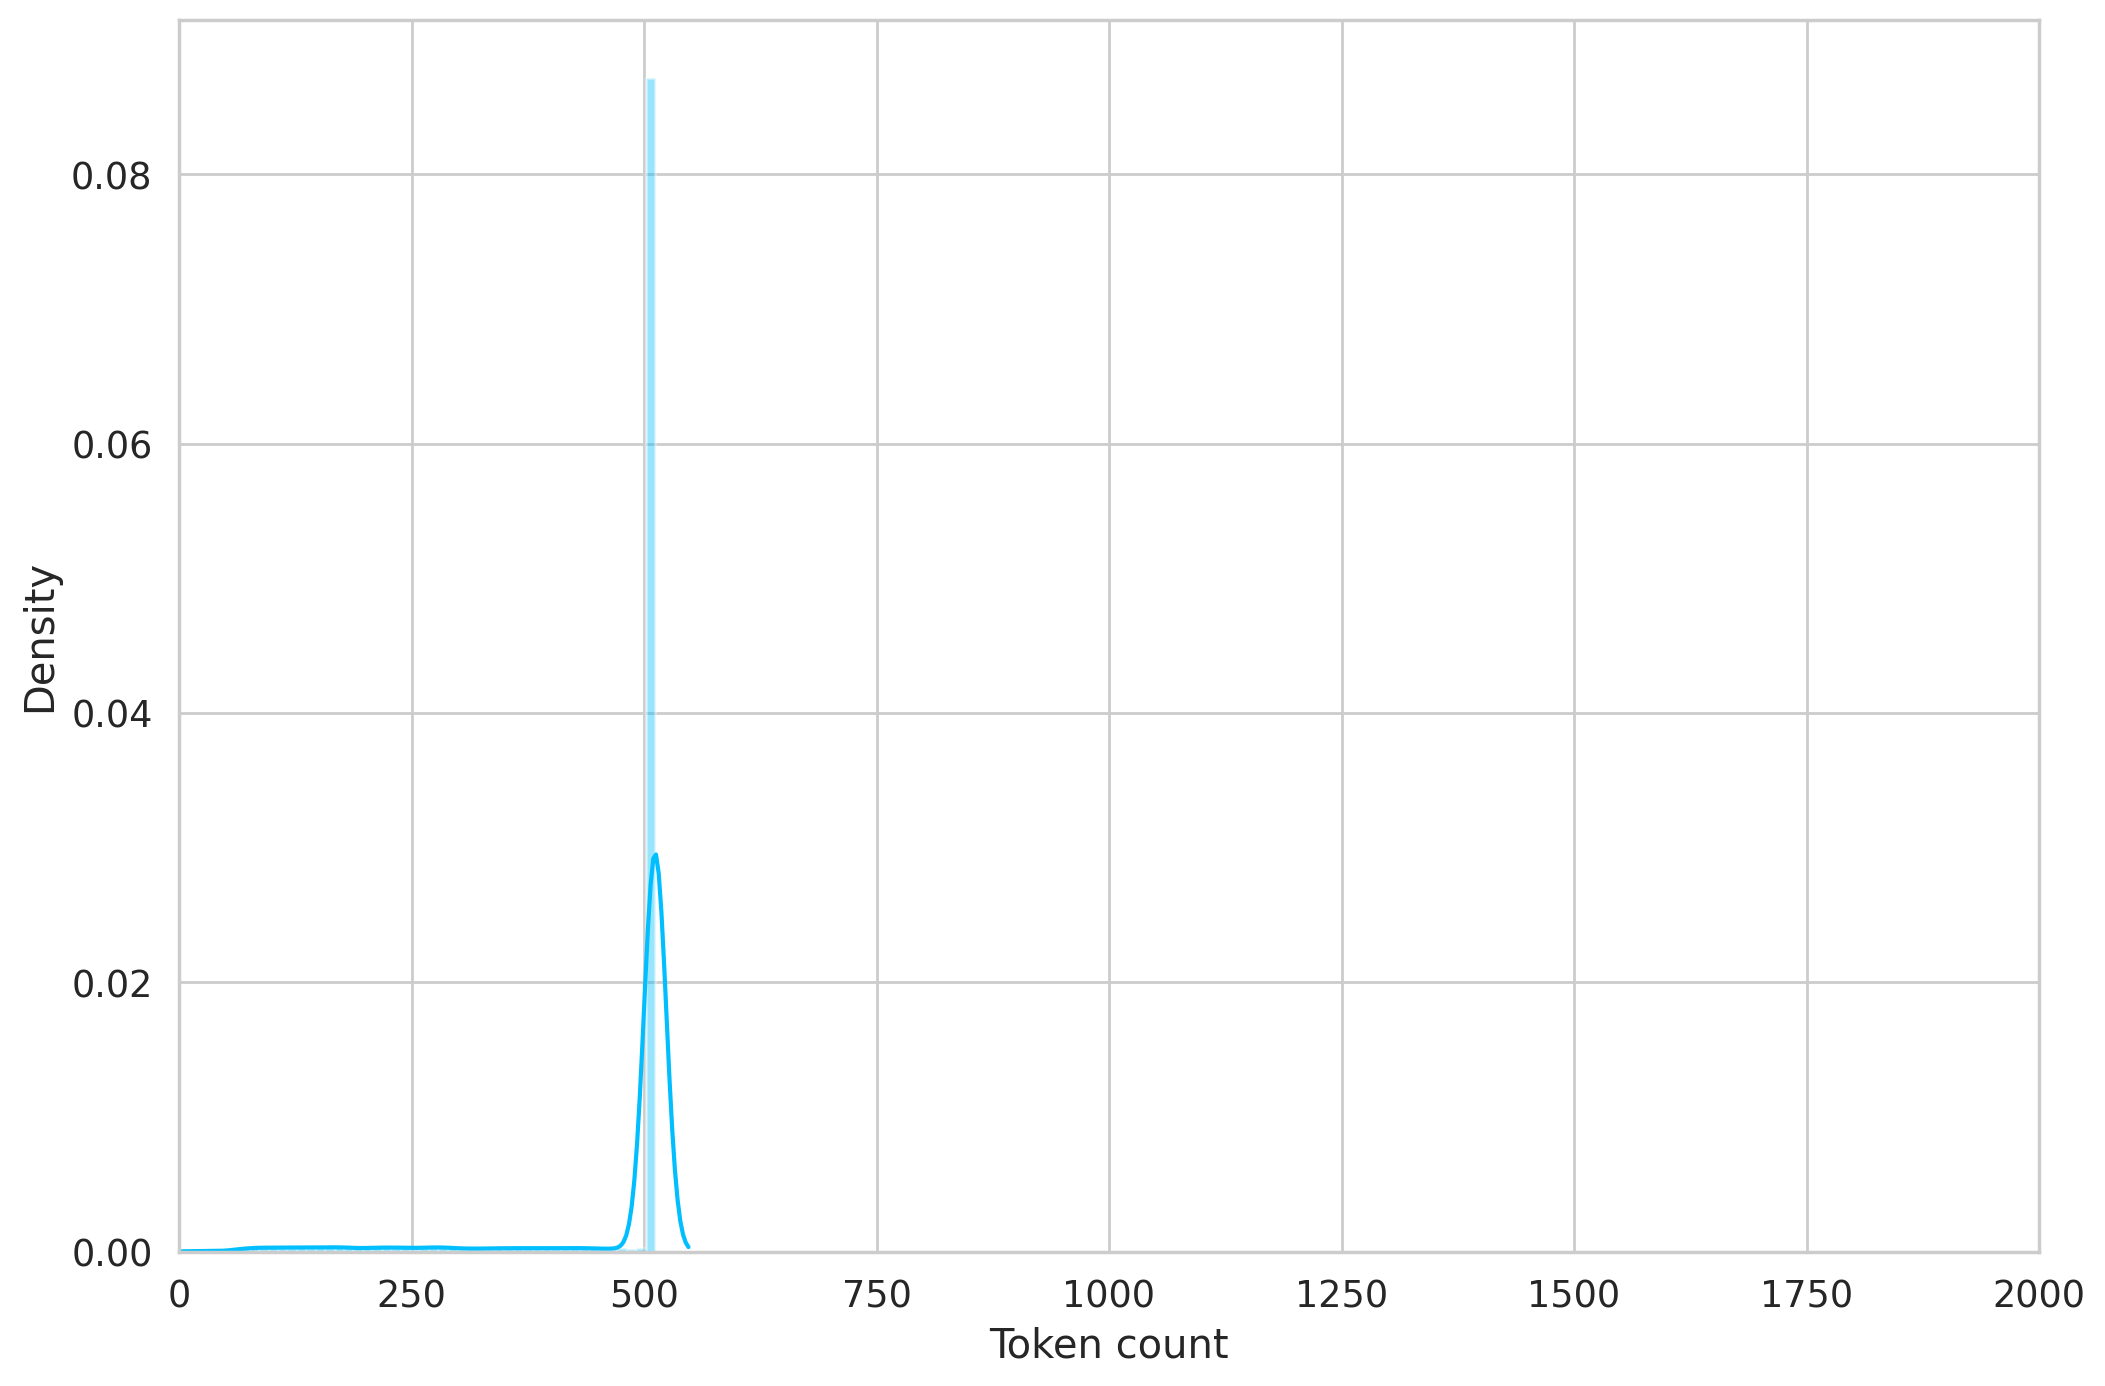

In [9]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 2000]);
plt.xlabel('Token count')

In [10]:
MAX_LEN = 512

## Creating a class for the sentences

In [11]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True # Add truncation here
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

## Splitting into training, validation and test data

In [12]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(16889, 4) (3619, 4) (3620, 4)


In [13]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

## Fixing Batch Size

In [14]:
 # Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [15]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


In [16]:

bert_model = AutoModel.from_pretrained("law-ai/InLegalBERT")

In [17]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load InLegalLLaMA model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("sudipto-ducs/InLegalLLaMA")
model = AutoModelForCausalLM.from_pretrained("sudipto-ducs/InLegalLLaMA")

def redact_judgment(text):
    """
    Redacts the final decision or ruling from a judgment using InLegalLLaMA.
    """
    prompt = f"""
    You are a legal assistant. Your task is to redact the part of a judgment where the judge explicitly states the final decision or ruling (i.e., whether the petition is allowed or dismissed). 

    Remove any sentences that:
    Reveal the final outcome
    Begin with phrases like "The appeal is allowed", "The petition is dismissed", etc.
    Clearly state what the court has decided

    Keep the rest of the judgment unchanged.

    Judgment:
    \"\"\"{text}\"\"\"

    Redacted Judgment:
    """
    
    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)
    outputs = model.generate(**inputs, max_length=2048, num_return_sequences=1, temperature=0.7)
    redacted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract the redacted judgment from the output
    redacted_text = redacted_text.split("Redacted Judgment:")[1].strip()
    return redacted_text

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [18]:
from tqdm import tqdm

def batch_redact(df, batch_size=32):
    redacted_texts = []
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df['text'].iloc[i:i+batch_size].tolist()
        redacted_batch = [redact_judgment(text) for text in batch]
        redacted_texts.extend(redacted_batch)
    return redacted_texts

df['redacted_text'] = batch_redact(df)
print(df['redacted_text'].head())

  0%|          | 0/754 [00:00<?, ?it/s]


NameError: name 'redact_judgment' is not defined

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load InLegalLLaMA model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("sudipto-ducs/InLegalLLaMA")
model = AutoModelForCausalLM.from_pretrained("sudipto-ducs/InLegalLLaMA")

def redact_single_sample(text):
    """
    Redacts the final decision or ruling from a judgment using InLegalLLaMA.
    """
    prompt = f"""
    You are a legal assistant. Your task is to redact the part of a judgment where the judge explicitly states the final decision or ruling (i.e., whether the petition is allowed or dismissed). 

    Remove any sentences that:
    Reveal the final outcome
    Begin with phrases like "The appeal is allowed", "The petition is dismissed", etc.
    Clearly state what the court has decided

    Keep the rest of the judgment unchanged.

    Judgment:
    \"\"\"{text}\"\"\"

    Redacted Judgment:
    """
    
    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)
    outputs = model.generate(**inputs, max_length=2048, num_return_sequences=1, temperature=0.7)
    redacted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract the redacted judgment from the output
    redacted_text = redacted_text.split("Redacted Judgment:")[1].strip()
    return redacted_text

# Example usage
sample_text = df['text'].iloc[0]  # Get the first sample text
redacted_text = redact_single_sample(sample_text)
print("Original Text:\n", sample_text)
print("\nRedacted Text:\n", redacted_text)

tokenizer_config.json: 0.00B [00:00, ?B/s]

c:\Users\Anna\miniconda3\envs\ml-env\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Anna\.cache\huggingface\hub\models--sudipto-ducs--InLegalLLaMA. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

ValueError: Cannot instantiate this tokenizer from a slow version. If it's based on sentencepiece, make sure you have sentencepiece installed.

## Applying the model

In [2]:

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = model = AutoModel.from_pretrained("law-ai/InLegalBERT")
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        # Ensure BERT model returns tensors
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]  # Typically, the second item is the pooled output

        # Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)


NameError: name 'nn' is not defined

In [21]:
# Instantiate the model and move to classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(2)
model = model.to(device)
from torch.optim import AdamW


In [22]:
print(bert_model.config.hidden_size)

768


## Epochs

In [23]:
from torch.optim import AdamW
from transformers.optimization import get_linear_schedule_with_warmup

EPOCHS = 5

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [24]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.682324106946136 accuracy 0.5736278050802297
Val   loss 0.6778463305093119 accuracy 0.568941696601271

Epoch 2/5
----------
Train loss 0.6451837611808018 accuracy 0.6242524720232103
Val   loss 0.7019620886983325 accuracy 0.5667311411992263

Epoch 3/5
----------
Train loss 0.5753445189559099 accuracy 0.6967256794363195
Val   loss 0.7910635676152906 accuracy 0.568941696601271

Epoch 4/5
----------
Train loss 0.4812336575917222 accuracy 0.7680738942506957
Val   loss 0.8022396084626866 accuracy 0.5910472506217187

Epoch 5/5
----------
Train loss 0.41455875031621847 accuracy 0.8089880987625081
Val   loss 0.8406062779316293 accuracy 0.6164686377452335

CPU times: user 32min 37s, sys: 1min 3s, total: 33min 40s
Wall time: 31min 55s


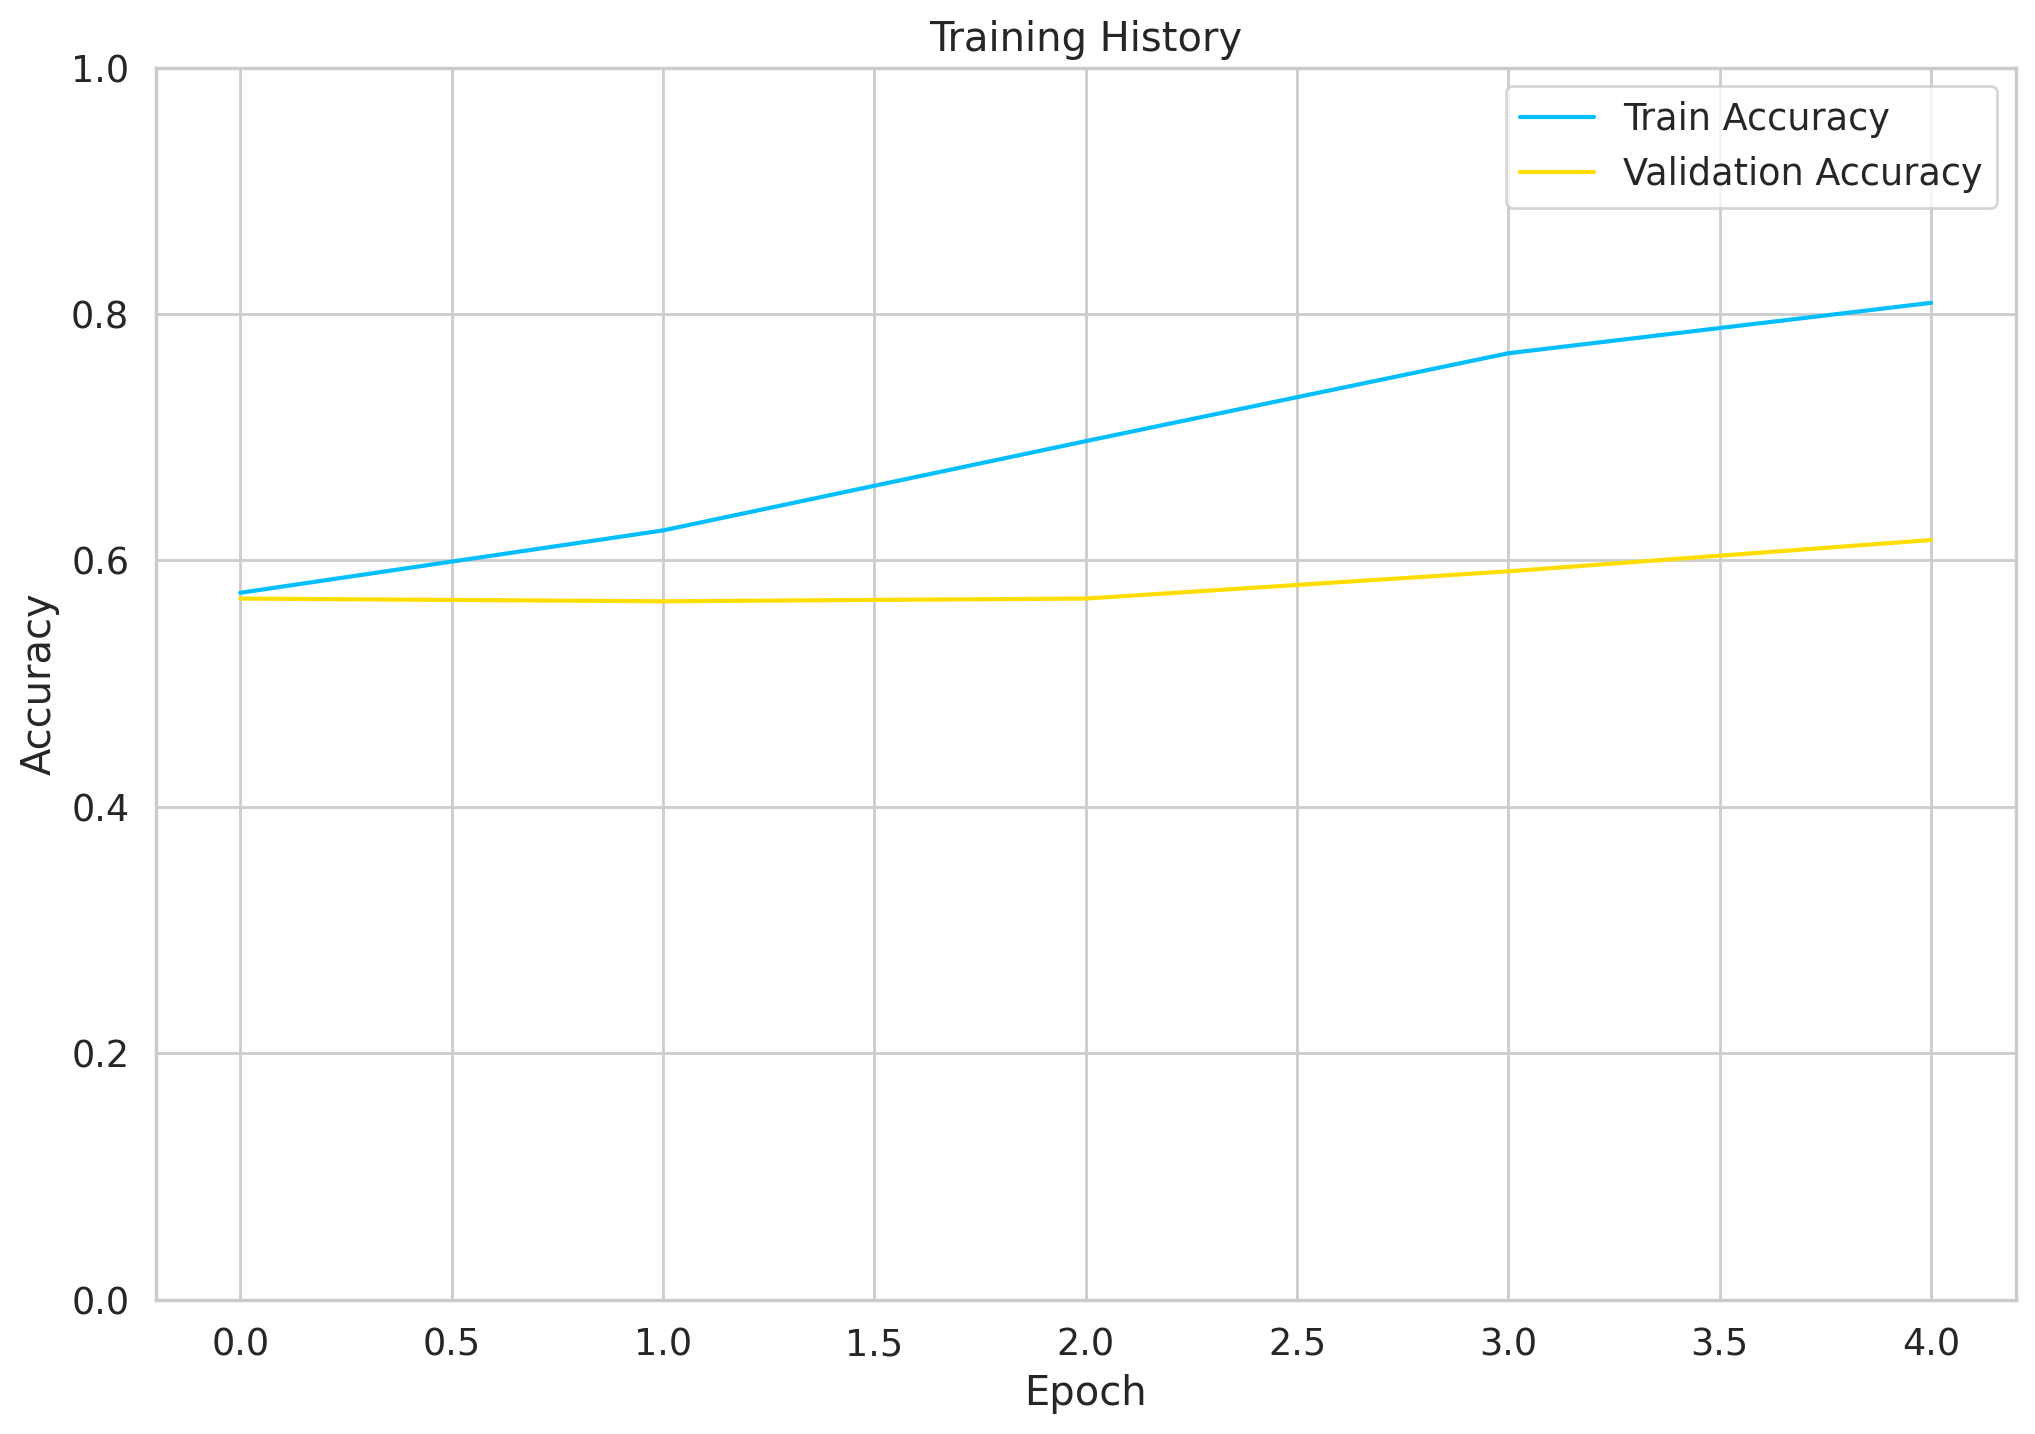

In [28]:
plt.plot([x.cpu().item() if torch.is_tensor(x) else x for x in history['train_acc']], label='Train Accuracy')
plt.plot([x.cpu().item() if torch.is_tensor(x) else x for x in history['val_acc']], label='Validation Accuracy')

plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.grid(True)
plt.show()


## Evaluating results

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()


In [29]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [30]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69      2154
           1       0.54      0.50      0.52      1466

    accuracy                           0.63      3620
   macro avg       0.61      0.61      0.61      3620
weighted avg       0.62      0.63      0.62      3620



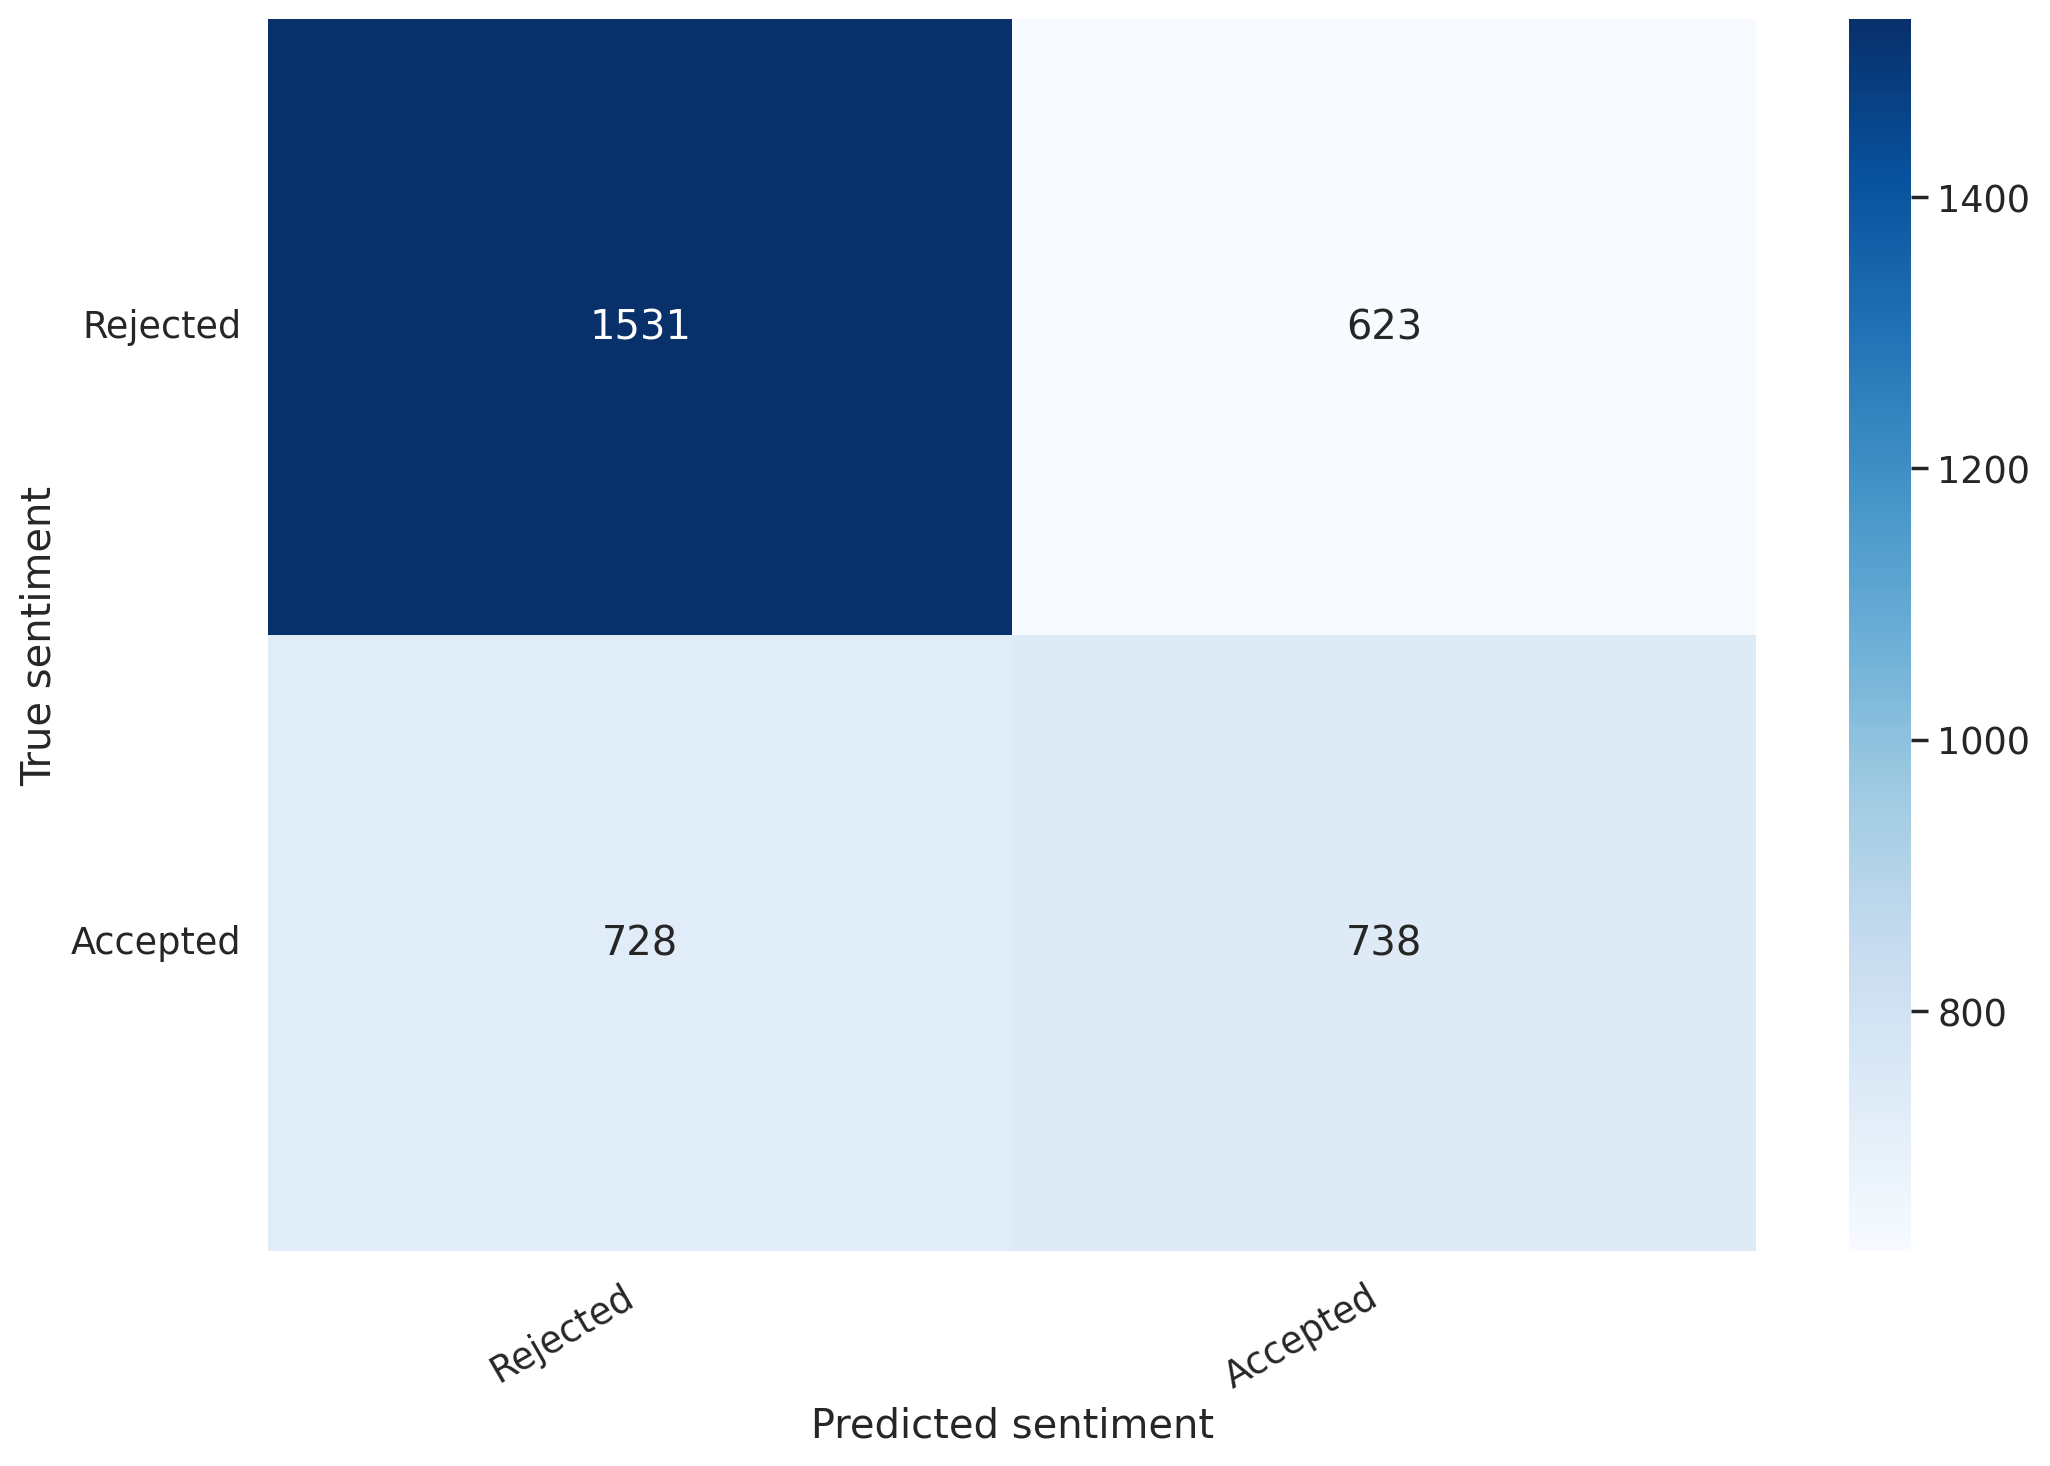

In [32]:
class_names = ["Rejected","Accepted"]
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=["Rejected","Accepted"])
show_confusion_matrix(df_cm)

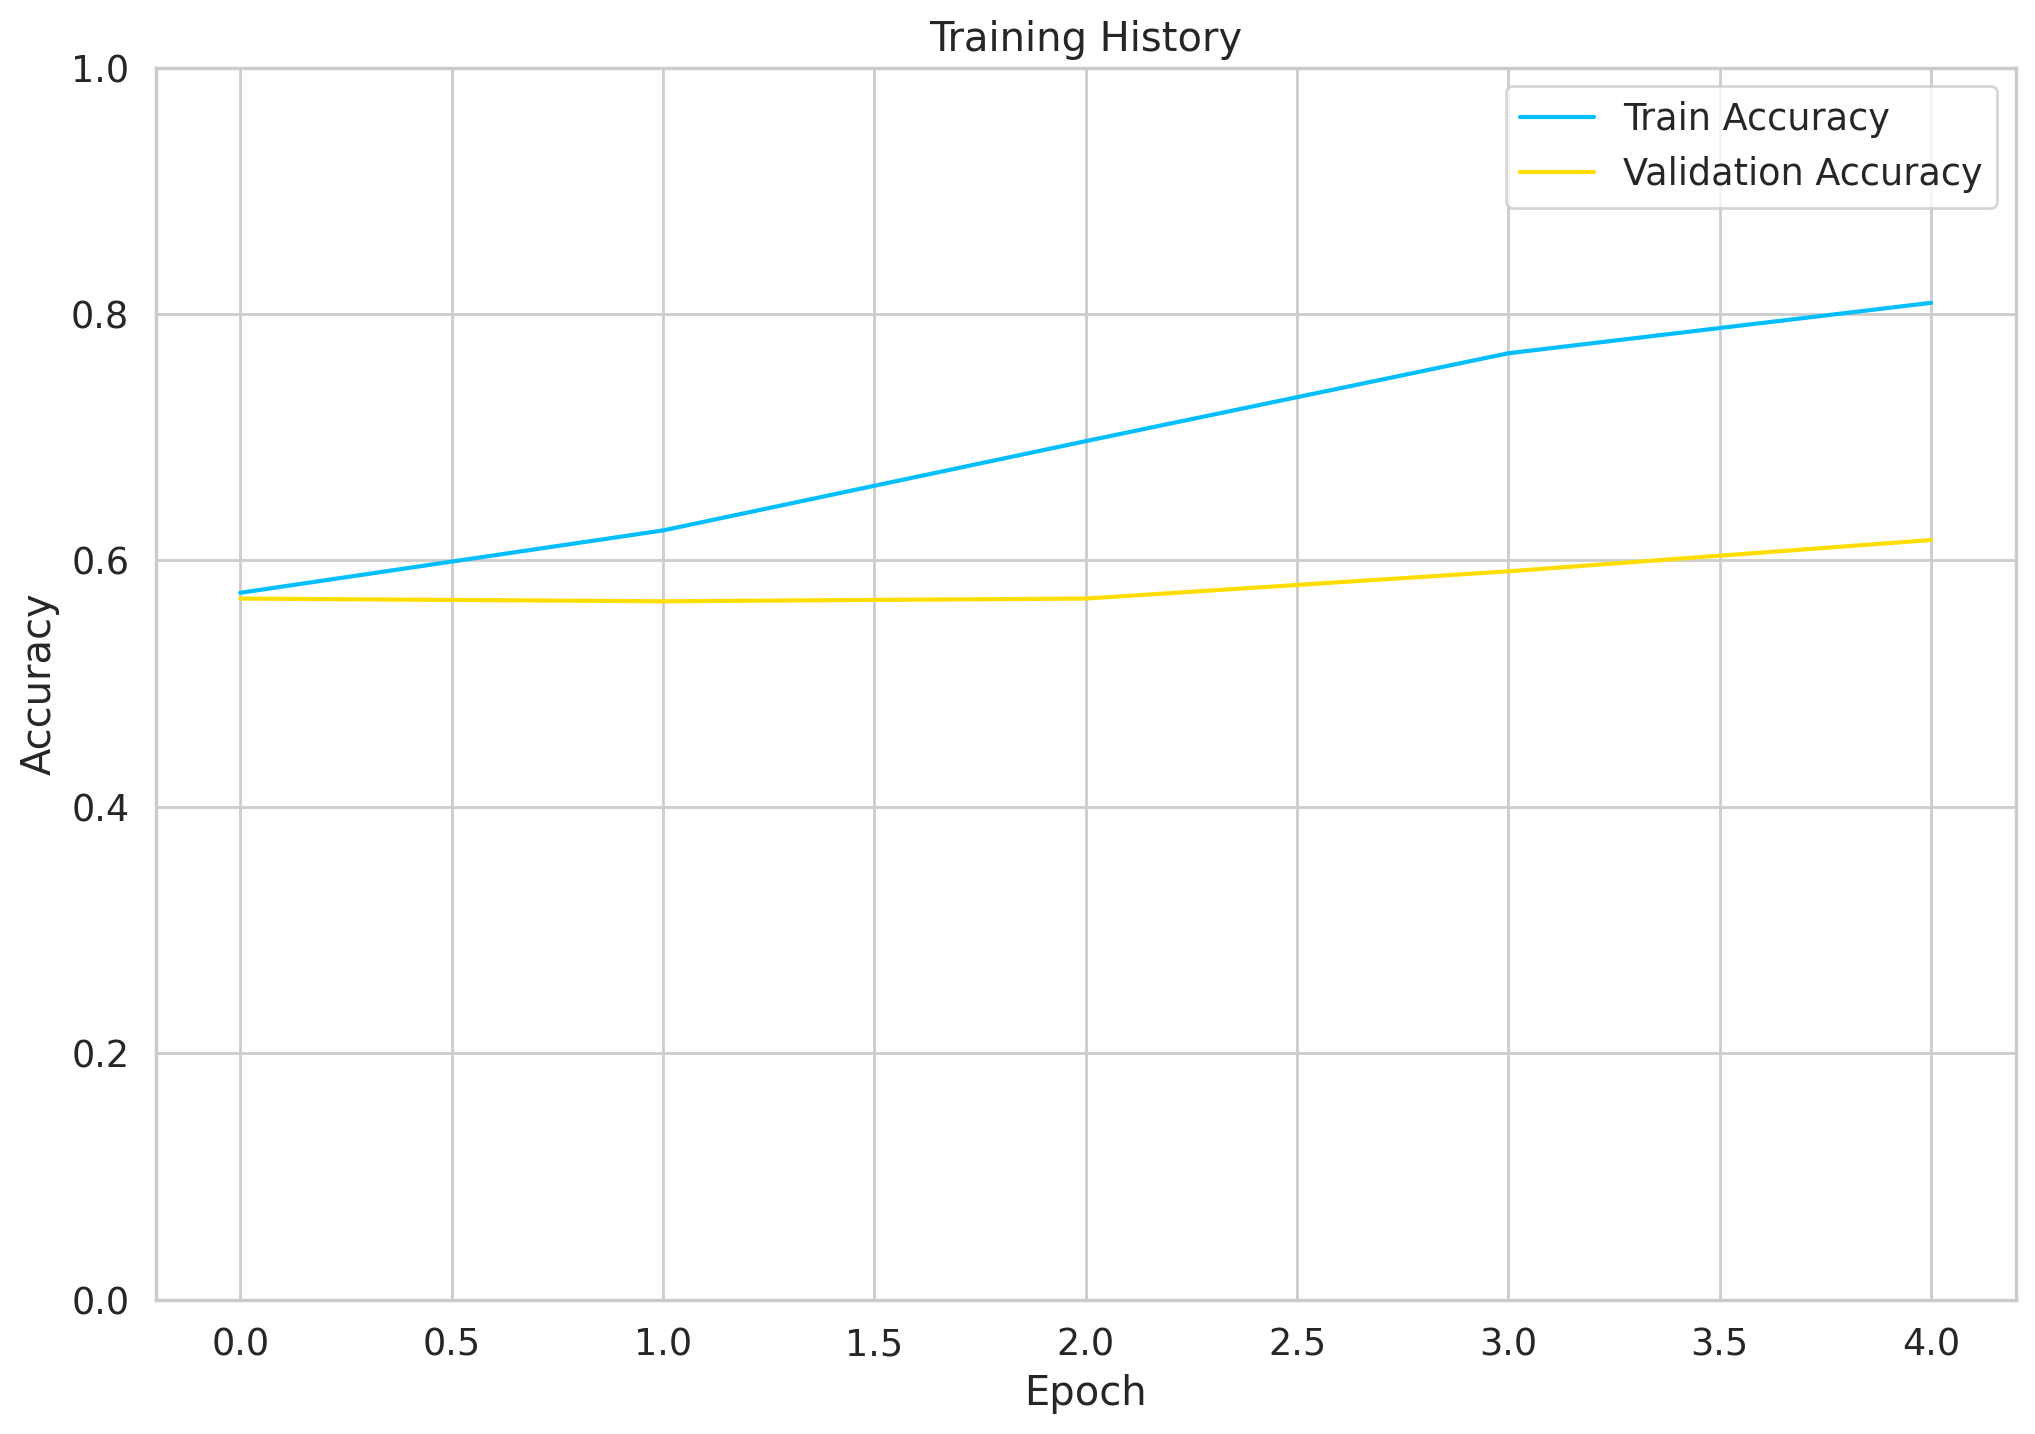

In [33]:
plt.plot([x.cpu().item() if torch.is_tensor(x) else x for x in history['train_acc']], label='Train Accuracy')
plt.plot([x.cpu().item() if torch.is_tensor(x) else x for x in history['val_acc']], label='Validation Accuracy')

plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.grid(True)
plt.show()


In [1]:
# Define the model architecture (must match the saved model)
model = SentimentClassifier(2)  # Replace with your model class and parameters
model = model.to(device)

# Load the saved state dictionary
model.load_state_dict(torch.load('best_model_state.bin'))

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")

NameError: name 'SentimentClassifier' is not defined

In [34]:
def predict_fn(texts):
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()

    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512  # Limit input length to 512 tokens
    )

    # Remove token_type_ids if not accepted by model
    if 'token_type_ids' in inputs:
        del inputs['token_type_ids']

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)  # returns logits
        probs = torch.nn.functional.softmax(outputs, dim=1)

    return probs.cpu().numpy()



In [46]:
import shap

# Define the SHAP explainer
explainer = shap.Explainer(predict_fn, shap.maskers.Text(tokenizer))

In [47]:
from IPython.core.display import display, HTML

idx = 2528
# ...existing code...
print(df_test["text"])
# ...existing code...
sentence = df_test["text"][idx]

# Run prediction
probs = predict_fn([sentence])
pred_class = probs.argmax(axis=1)[0]

print("🔴 Red = pushes toward prediction, 🔵 Blue = pushes against prediction")
print("Predicted class:", "Affirmative" if pred_class == 1 else "Negative")

# Compute SHAP explanation only for this sentence
shap_values = explainer([sentence])

# Slice explanation for predicted class only
shap_exp = shap_values[0, :, pred_class]  # Only one explanation returned

# Visualize
shap_html = shap.plots.text(shap_exp, display=False)
html_string = shap_html if isinstance(shap_html, str) else shap_html.data
display(HTML(html_string))


14131    CRIMINAL APPELLATE JURISDICTION Criminal Appea...
1693     KURIAN, J. Leave granted. The matter pertains ...
14255    CIVIL APPELLATe JURISDICTION Civil Appeal No. ...
2528      These petitions have been filed challenging t...
4516      Gokhale J. This appeal seeks to challenge the...
                               ...                        
20863     Murari Mohan Dutt, J. In this case the petiti...
12800     LITTTTTTJ J U D G M E N T BANERJEE,J. This ba...
12304     Appeal  civil  1902 of J U D G M E N T S. N. ...
18716    CIVIL APPELLATE JURISDICTION Civil Appeal No. ...
14112    CRIMINAL APPELLATE JURISDICTION Criminal Appea...
Name: text, Length: 3620, dtype: object
🔴 Red = pushes toward prediction, 🔵 Blue = pushes against prediction
Predicted class: Negative


In [48]:
# Calculate SHAP values for the first 100 test sentences
from tqdm import tqdm  # For progress bar

num_samples = 100
sentences = df_test["text"].iloc[:num_samples].tolist()
all_shap_values = []

for sentence in tqdm(sentences, desc="Calculating SHAP values"):
    shap_values = explainer([sentence])
    all_shap_values.append(shap_values)

print("Done calculating SHAP values for the first 100 test sentences.")

# Example: Visualize the SHAP explanation for the first sentence
shap_exp = all_shap_values[0][0, :, all_shap_values[0][0].values[0].argmax()]  # For predicted class
shap_html = shap.plots.text(shap_exp, display=False)
html_string = shap_html if isinstance(shap_html, str) else shap_html.data
display(HTML(html_string))

PartitionExplainer explainer: 2it [00:18, 18.37s/it]               
PartitionExplainer explainer: 2it [00:35, 35.65s/it]               s/it]
PartitionExplainer explainer: 2it [00:17, 17.84s/it]               s/it]
PartitionExplainer explainer: 2it [00:10, 10.10s/it]               s/it]
PartitionExplainer explainer: 2it [00:16, 16.59s/it]               s/it]
PartitionExplainer explainer: 2it [00:20, 20.42s/it]               s/it]
PartitionExplainer explainer: 2it [00:37, 37.34s/it]               7s/it]
PartitionExplainer explainer: 2it [00:32, 32.57s/it]               4s/it]
PartitionExplainer explainer: 2it [00:27, 27.33s/it]               4s/it]
PartitionExplainer explainer: 2it [00:32, 32.79s/it]               9s/it]
PartitionExplainer explainer: 2it [00:51, 51.72s/it]               2s/it]
PartitionExplainer explainer: 2it [00:16, 16.38s/it]               9s/it]
PartitionExplainer explainer: 2it [00:13, 13.47s/it]               1s/it]
PartitionExplainer explainer: 2it [00:27, 27.29s/

Done calculating SHAP values for the first 100 test sentences.


In [37]:
def predict_with_embedding_noise(texts, noise_std=0.1):
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()

    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        # Get embeddings and add noise
        embeddings = model.bert.embeddings(input_ids=inputs['input_ids'])
        noise = torch.randn_like(embeddings) * noise_std
        noisy_embeddings = embeddings + noise

        # Prepare attention mask for encoder
        attention_mask = inputs['attention_mask']
        extended_attention_mask = attention_mask[:, None, None, :]  # (batch, 1, 1, seq_len)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        # Pass through BERT encoder
        encoder_outputs = model.bert.encoder(noisy_embeddings, attention_mask=extended_attention_mask)[0]
        pooled_output = encoder_outputs[:, 0, :]  # CLS token

        # Pass through classifier head
        output = model.drop(pooled_output)
        logits = model.out(output)
        probs = torch.nn.functional.softmax(logits, dim=-1)
    return probs.cpu().numpy()

In [38]:
probs = predict_with_embedding_noise([sentence], noise_std=0.1)

In [39]:
print(probs)
print("Predicted class:", "Affirmative" if probs.argmax() == 1 else "Negative")

[[0.64581496 0.35418501]]
Predicted class: Negative


In [42]:
from tqdm import tqdm

# 1. Calculate SHAP values with noise for the first 100 test sentences
noisy_shap_values = []
for sentence in tqdm(sentences, desc="Calculating SHAP values with noise"):
    shap_vals = shap.Explainer(
        lambda x: predict_with_embedding_noise(x, noise_std=0.1), 
        shap.maskers.Text(tokenizer)
    )([sentence])
    noisy_shap_values.append(shap_vals)

print("Done calculating SHAP values with noise.")

# 2. Example: Compare SHAP values for the first sentence
# Visualize original SHAP
shap_exp_orig = all_shap_values[0][0, :, all_shap_values[0][0].values[0].argmax()]
shap_html_orig = shap.plots.text(shap_exp_orig, display=False)
display(HTML(shap_html_orig if isinstance(shap_html_orig, str) else shap_html_orig.data))

# Visualize noisy SHAP
shap_exp_noisy = noisy_shap_values[0][0, :, noisy_shap_values[0][0].values[0].argmax()]
shap_html_noisy = shap.plots.text(shap_exp_noisy, display=False)
display(HTML(shap_html_noisy if isinstance(shap_html_noisy, str) else shap_html_noisy.data))

# 3. (Optional) Quantitative comparison: Mean absolute difference for each token
import numpy as np

orig_vals = all_shap_values[0][0].values
noisy_vals = noisy_shap_values[0][0].values
mean_abs_diff = np.mean(np.abs(orig_vals - noisy_vals))
print("Mean absolute SHAP difference (first sentence):", mean_abs_diff)

PartitionExplainer explainer: 2it [00:18, 18.08s/it]               , ?it/s]
PartitionExplainer explainer: 2it [00:37, 37.42s/it]               3:08,  8.05s/it]
PartitionExplainer explainer: 2it [00:18, 18.70s/it]               4:24, 15.26s/it]
PartitionExplainer explainer: 2it [00:11, 11.65s/it]               6:07, 16.50s/it]
PartitionExplainer explainer: 2it [00:16, 16.93s/it]               3:16, 14.86s/it]
PartitionExplainer explainer: 2it [00:21, 21.66s/it]               7:11, 11.21s/it]
PartitionExplainer explainer: 2it [00:37, 37.00s/it]               13:30,  9.10s/it]
PartitionExplainer explainer: 2it [00:34, 34.52s/it]               25:48, 17.60s/it]
PartitionExplainer explainer: 2it [00:28, 28.64s/it]               13:00,  9.40s/it]
PartitionExplainer explainer: 2it [00:32, 32.33s/it]               20:45, 15.19s/it]
PartitionExplainer explainer: 2it [00:51, 51.66s/it]               15:03, 11.43s/it]
PartitionExplainer explainer: 2it [00:17, 17.38s/it]               22:31, 17.55

Done calculating SHAP values with noise.


IndexError: list index out of range

In [50]:
# 2. Example: Compare SHAP values for the first sentence
# Visualize original SHAP
shap_exp_orig = all_shap_values[0][0, :, all_shap_values[0][0].values[0].argmax()]
shap_html_orig = shap.plots.text(shap_exp_orig, display=False)
display(HTML(shap_html_orig if isinstance(shap_html_orig, str) else shap_html_orig.data))

# Visualize noisy SHAP
shap_exp_noisy = noisy_shap_values[0][0, :, noisy_shap_values[0][0].values[0].argmax()]
shap_html_noisy = shap.plots.text(shap_exp_noisy, display=False)
display(HTML(shap_html_noisy if isinstance(shap_html_noisy, str) else shap_html_noisy.data))

# 3. (Optional) Quantitative comparison: Mean absolute difference for each token
import numpy as np

orig_vals = all_shap_values[0][0].values
noisy_vals = noisy_shap_values[0][0].values
mean_abs_diff = np.mean(np.abs(orig_vals - noisy_vals))
print("Mean absolute SHAP difference (first sentence):", mean_abs_diff)

Mean absolute SHAP difference (first sentence): 9.427495998653711e-05


In [44]:
print("Number of SHAP values calculated:", len(all_shap_values))

Number of SHAP values calculated: 0


original logits: [-9.59175119e-05  9.59175554e-05]
noisy logits: [-5.00395774e-05  5.00396766e-05]
original logits: [-0.00010916  0.00010916]
noisy logits: [ 0.00066291 -0.00066291]
original logits: [ 0.00030054 -0.00030054]
noisy logits: [-0.00011082  0.00011082]
original logits: [ 0.00025691 -0.00025691]
noisy logits: [-0.00014869  0.00014869]
original logits: [-0.00055582  0.00055582]
noisy logits: [-0.00013844  0.00013844]
original logits: [ 5.44555853e-05 -5.44556513e-05]
noisy logits: [ 0.00014184 -0.00014184]
original logits: [-0.00016268  0.00016267]
noisy logits: [-6.71727295e-05  6.71728236e-05]
original logits: [ 0.00182666 -0.00182666]
noisy logits: [ 3.03550619e-05 -3.03550491e-05]
original logits: [ 9.96194948e-05 -9.96195548e-05]
noisy logits: [ 5.27160809e-05 -5.27160875e-05]
original logits: [ 0.00010315 -0.00010315]
noisy logits: [-0.0007029  0.0007029]
original logits: [-0.00013955  0.00013955]
noisy logits: [-0.00130534  0.00130534]
original logits: [ 0.0003085 -0.0

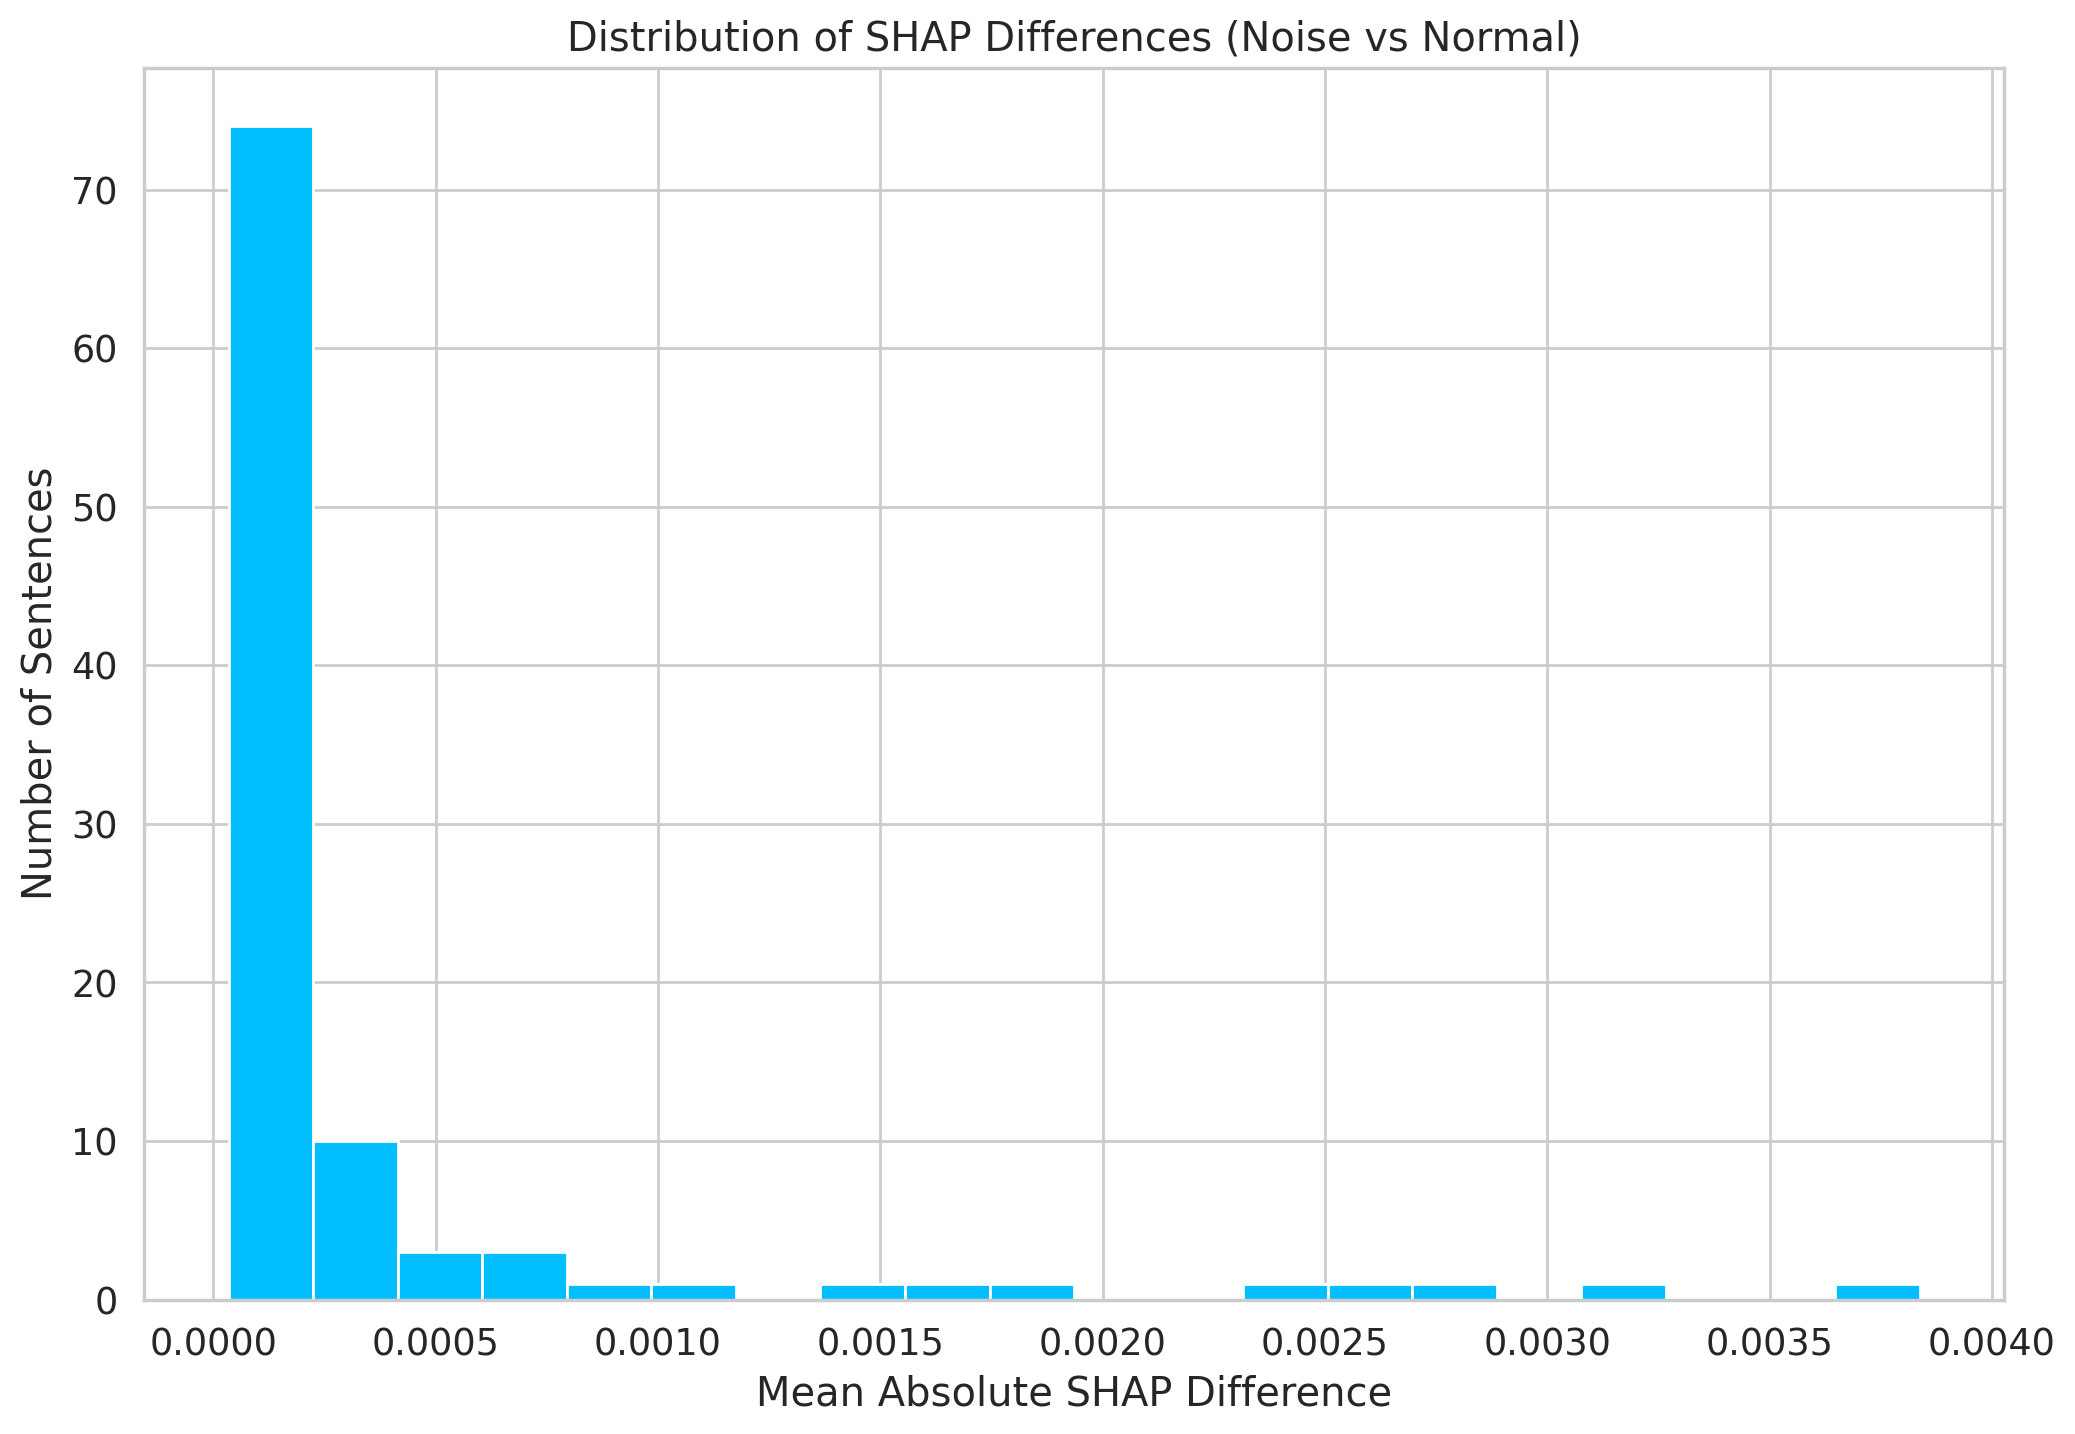

In [51]:
import numpy as np

mean_abs_diffs = []
flip_count = 0
flip_indices = []

for i, (orig, noisy) in enumerate(zip(all_shap_values, noisy_shap_values)):
    # Get predicted class for normal and noisy
    print("original logits:", orig[0].values[0])
    print("noisy logits:", noisy[0].values[0])
    orig_pred = orig[0].values[0].argmax()
    noisy_pred = noisy[0].values[0].argmax()

    # Track flips
    if orig_pred != noisy_pred:
        flip_count += 1
        flip_indices.append(i)

    # Compare SHAP values for the predicted class (normal)
    orig_vals = orig[0].values
    noisy_vals = noisy[0].values
    diff = np.mean(np.abs(orig_vals - noisy_vals))
    mean_abs_diffs.append(diff)

print("Mean absolute SHAP difference (all sentences):")
print("Mean:", np.mean(mean_abs_diffs))
print("Std:", np.std(mean_abs_diffs))
print("Min:", np.min(mean_abs_diffs))
print("Max:", np.max(mean_abs_diffs))
print(f"Number of prediction flips: {flip_count} out of {len(all_shap_values)}")
print(f"Indices of flipped predictions: {flip_indices}")

# Optional: Visualize the distribution
import matplotlib.pyplot as plt
plt.hist(mean_abs_diffs, bins=20)
plt.xlabel("Mean Absolute SHAP Difference")
plt.ylabel("Number of Sentences")
plt.title("Distribution of SHAP Differences (Noise vs Normal)")
plt.show()

Mean absolute SHAP difference (all sentences):
Mean: 0.000911201151279358
Std: 0.0017636276180953577
Min: 2.7397450714235006e-05
Max: 0.011616407533519016


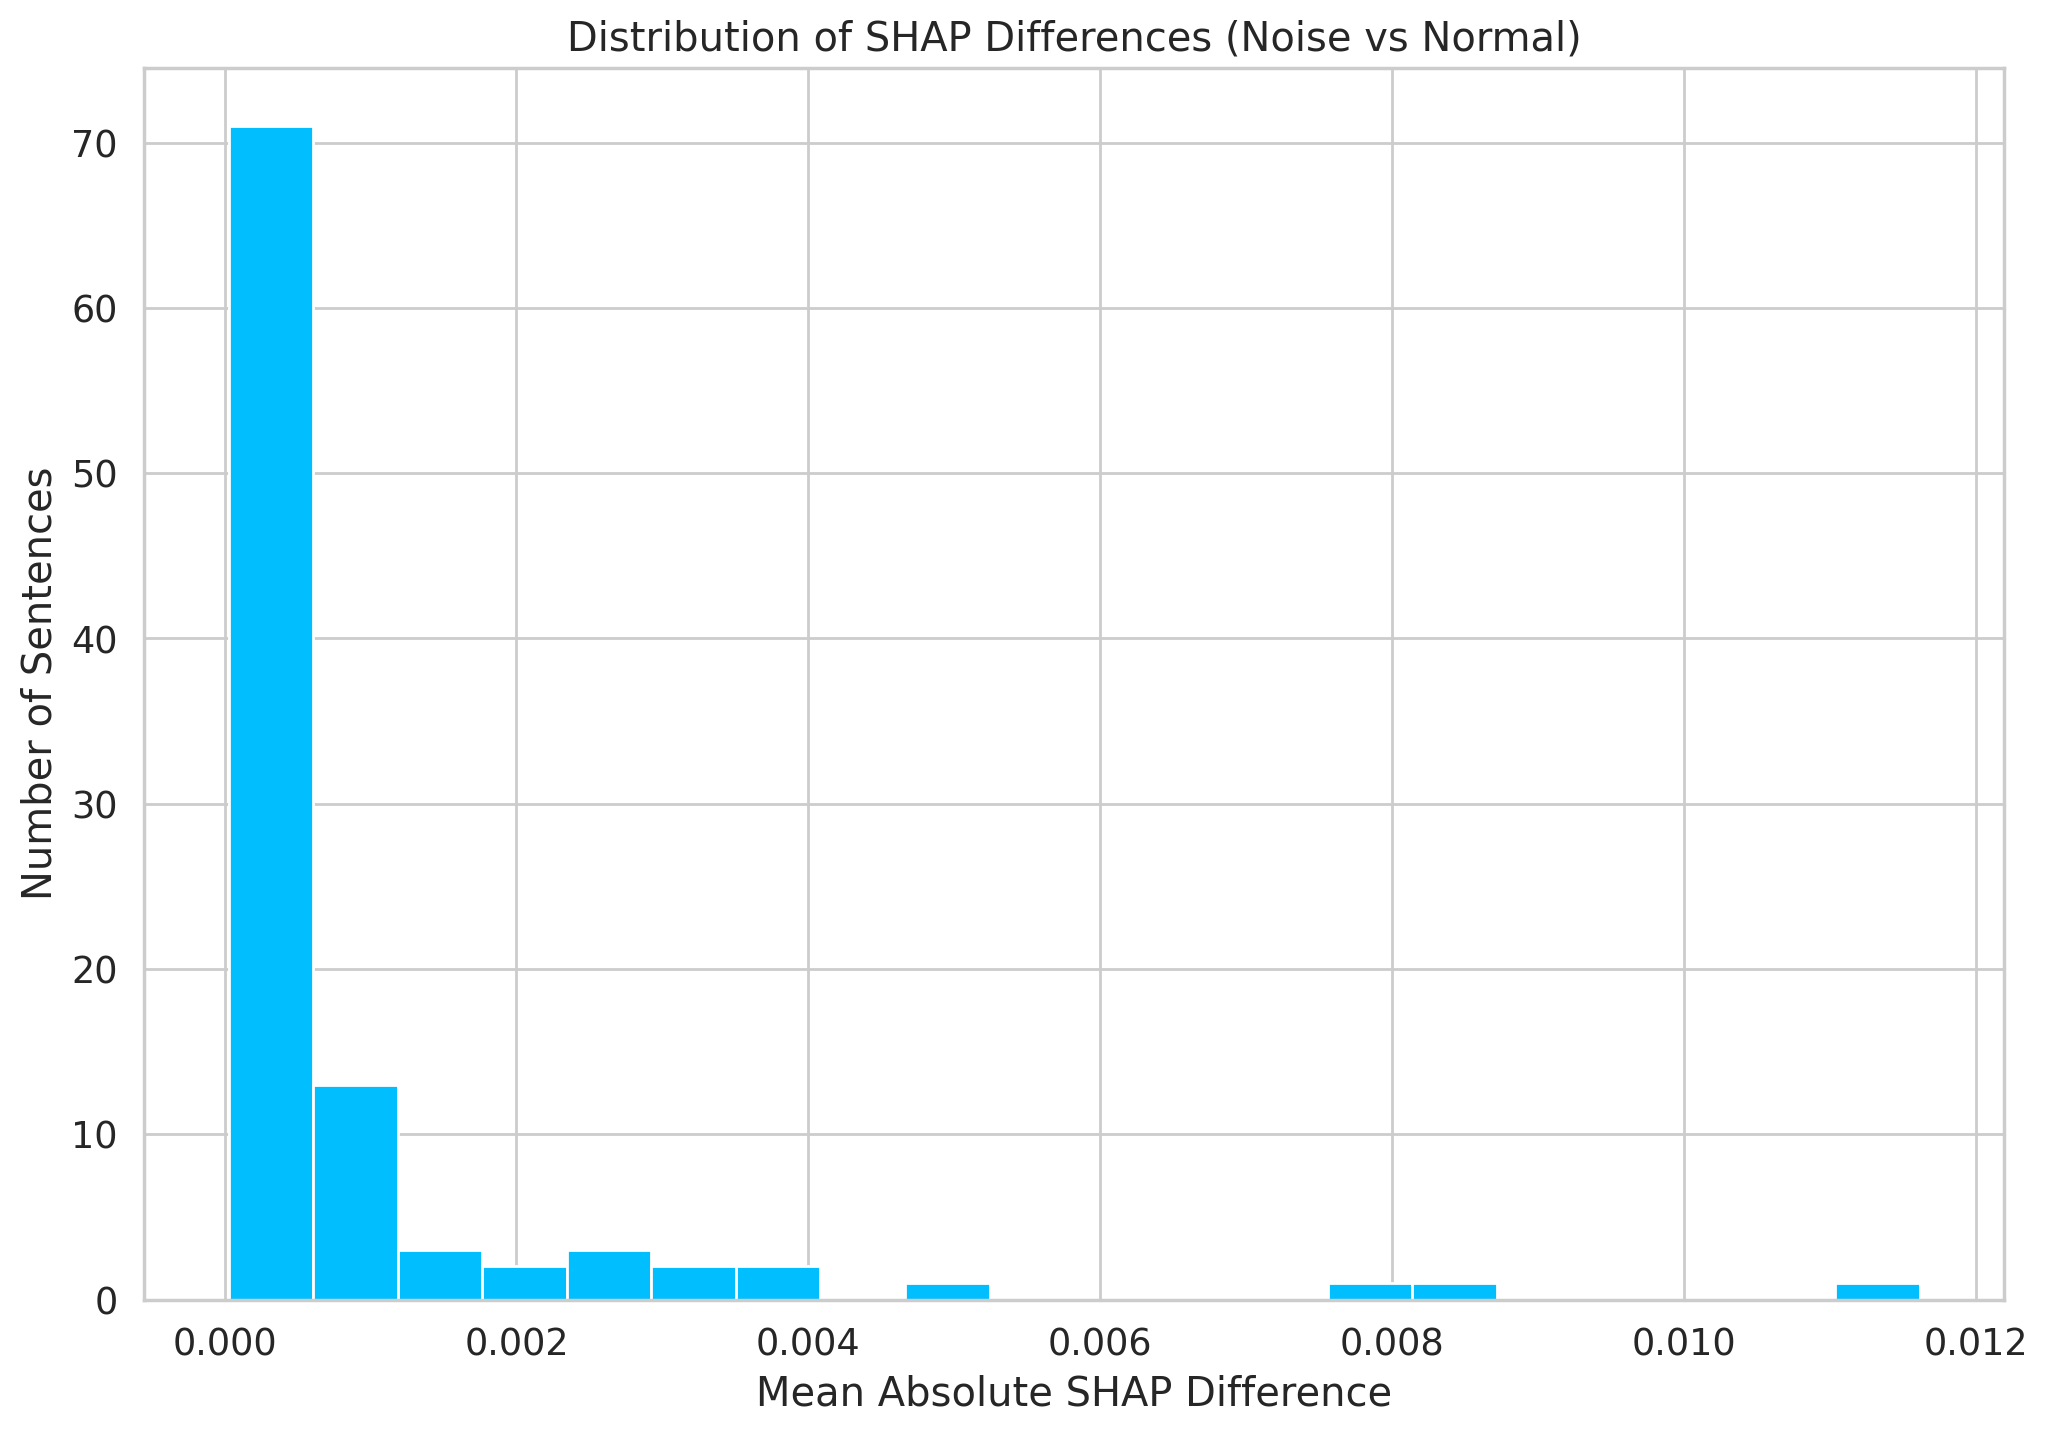

In [76]:
import numpy as np

# Store mean absolute SHAP differences for each sentence
mean_abs_diffs = []

for orig, noisy in zip(all_shap_values, noisy_shap_values):
    # Get SHAP values for the predicted class for each explanation
    orig_vals = orig[0].values
    noisy_vals = noisy[0].values

    # Compute mean absolute difference for all tokens and both classes
    diff = np.mean(np.abs(orig_vals - noisy_vals))
    mean_abs_diffs.append(diff)

# Print summary statistics
print("Mean absolute SHAP difference (all sentences):")
print("Mean:", np.mean(mean_abs_diffs))
print("Std:", np.std(mean_abs_diffs))
print("Min:", np.min(mean_abs_diffs))
print("Max:", np.max(mean_abs_diffs))

# Optional: Visualize the distribution
import matplotlib.pyplot as plt
plt.hist(mean_abs_diffs, bins=20)
plt.xlabel("Mean Absolute SHAP Difference")
plt.ylabel("Number of Sentences")
plt.title("Distribution of SHAP Differences (Noise vs Normal)")
plt.show()

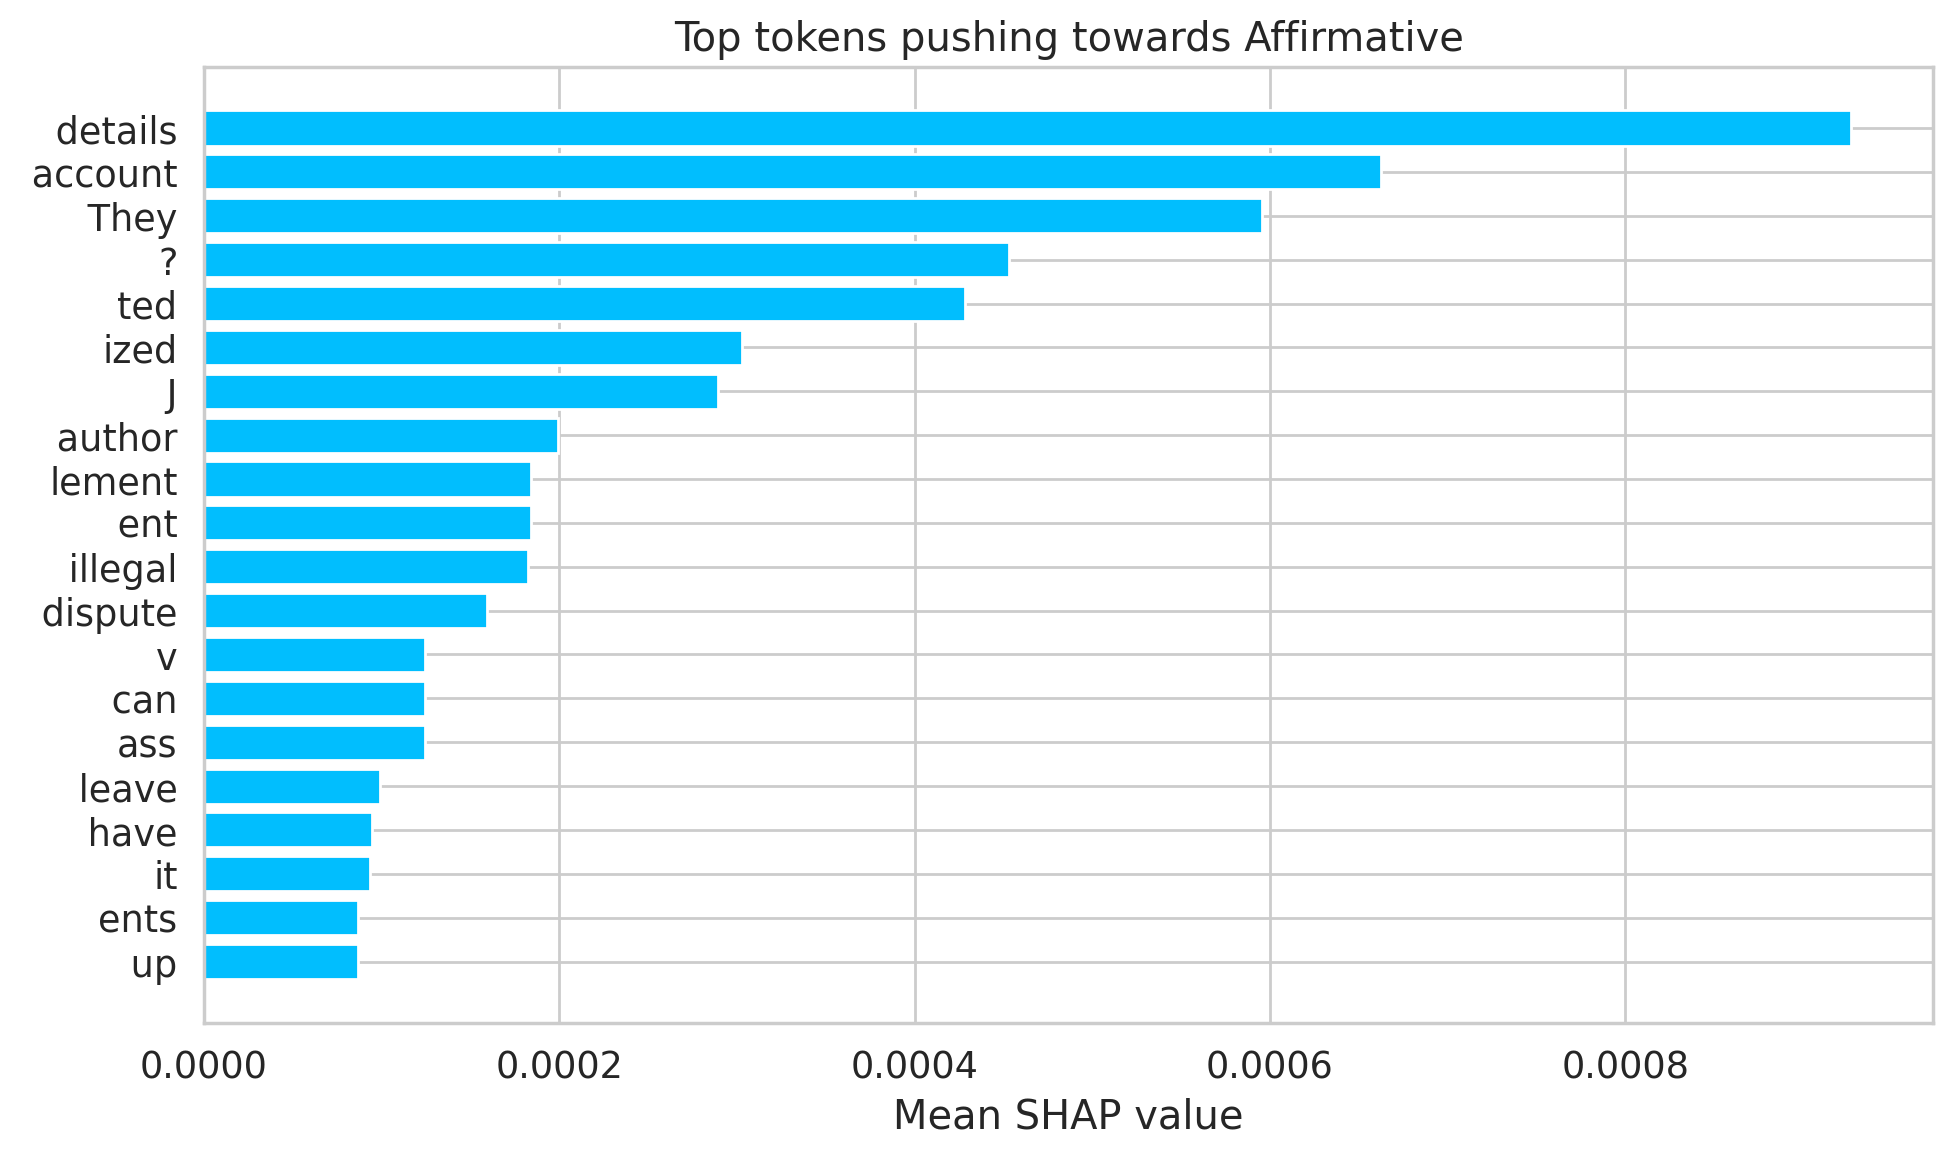

In [52]:
tokens = []
shaps = []

for exp in shap_values:
    for word, val in zip(exp.data, exp.values[:, 1]):  # Class 0
        tokens.append(word)
        shaps.append(val)

df = pd.DataFrame({'token': tokens, 'shap': shaps})
df = df.groupby("token", as_index=False)["shap"].mean().sort_values("shap", ascending=False)

# Top 20 positive SHAP values for Class 0
plt.figure(figsize=(10,6))
plt.barh(df["token"][:20][::-1], df["shap"][:20][::-1])
plt.xlabel("Mean SHAP value")
plt.title("Top tokens pushing towards Affirmative")
plt.tight_layout()
plt.show()


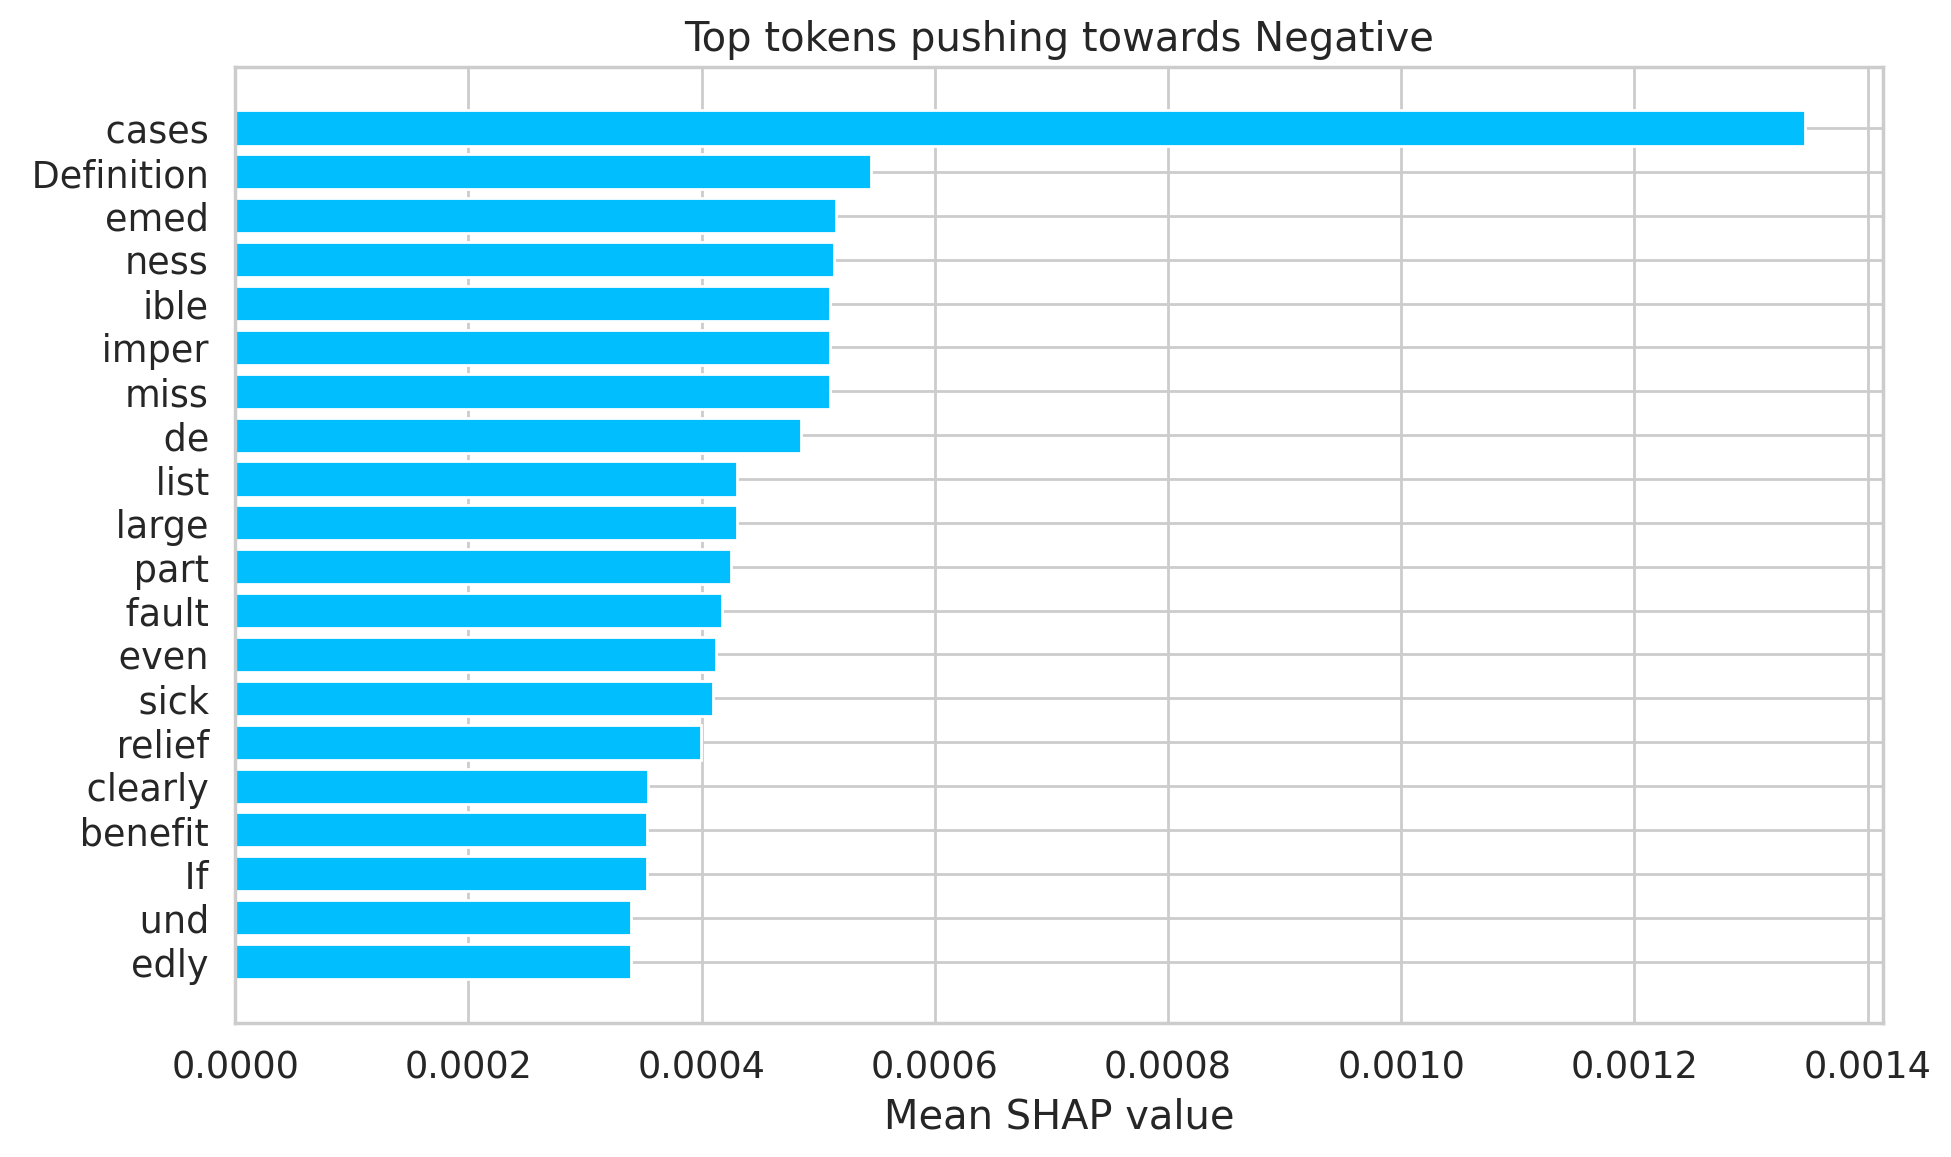

In [53]:
tokens = []
shaps = []

for exp in shap_values:
    for word, val in zip(exp.data, exp.values[:, 0]):  # Class 0
        tokens.append(word)
        shaps.append(val)

df = pd.DataFrame({'token': tokens, 'shap': shaps})
df = df.groupby("token", as_index=False)["shap"].mean().sort_values("shap", ascending=False)

# Top 20 positive SHAP values for Class 0
plt.figure(figsize=(10,6))
plt.barh(df["token"][:20][::-1], df["shap"][:20][::-1])
plt.xlabel("Mean SHAP value")
plt.title("Top tokens pushing towards Negative")
plt.tight_layout()
plt.show()


In [60]:
def predict_with_semantic_noise(
    texts: Union[List[str], np.ndarray],
    replace_prob: float = 0.1,
    mask_prob: float = 0.05,
    top_k_similar: int = 10,
    temperature: float = 1.0
):
    """
    Adds semantic noise to the input text by randomly replacing tokens with similar ones
    or masking tokens, and then predicts using the noisy text.

    Args:
        texts (Union[List[str], np.ndarray]): Input texts to process.
        replace_prob (float): Probability of replacing a token with a similar token.
        mask_prob (float): Probability of masking a token.
        top_k_similar (int): Number of top similar tokens to consider for replacement.
        temperature (float): Temperature for sampling similar tokens.

    Returns:
        np.ndarray: Predicted probabilities for the noisy text.
    """
    # Convert input if necessary
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    
    # Tokenize inputs
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(device)
    
    with torch.no_grad():
        # Get original input IDs
        input_ids = inputs['input_ids']
        
        # Create mask for where to add noise (excluding special tokens)
        special_tokens = set(tokenizer.all_special_ids)
        mask = torch.ones_like(input_ids, dtype=torch.bool)
        for token_id in special_tokens:
            mask &= (input_ids != token_id)
        
        # Initialize noisy input IDs
        noisy_input_ids = input_ids.clone()
        
        # Random replacement with similar tokens
        if replace_prob > 0:
            # Get token embeddings from the underlying BERT model
            embeddings = model.bert.get_input_embeddings()(torch.arange(tokenizer.vocab_size).to(device))
            
            # Calculate similarities
            input_embeddings = model.bert.get_input_embeddings()(input_ids)
            similarities = torch.matmul(input_embeddings, embeddings.T) / temperature
            
            # Sample replacement candidates
            _, top_k_indices = torch.topk(similarities, top_k_similar, dim=-1)
            
            # Create replacement mask
            replace_mask = (torch.rand_like(input_ids.float()) < replace_prob) & mask
            if replace_mask.any():
                # Select random similar tokens from top-k
                random_indices = torch.randint(1, top_k_similar, size=replace_mask.sum().shape)
                replacements = top_k_indices[replace_mask][torch.arange(replace_mask.sum()), random_indices]
                noisy_input_ids[replace_mask] = replacements
        
        # Random masking
        if mask_prob > 0 and tokenizer.mask_token_id is not None:
            mask_mask = (torch.rand_like(input_ids.float()) < mask_prob) & mask
            noisy_input_ids[mask_mask] = tokenizer.mask_token_id
        
        # Update inputs with noisy input IDs
        inputs['input_ids'] = noisy_input_ids
        
        # Pass through the model
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        probs = torch.nn.functional.softmax(outputs, dim=-1)
    
    return probs.cpu().numpy()

In [61]:
from tqdm import tqdm

# 1. Calculate SHAP values with noise for the first 100 test sentences
noisy_shap_values = []
for sentence in tqdm(sentences, desc="Calculating SHAP values with more noise"):
    shap_vals = shap.Explainer(
        lambda x: predict_with_semantic_noise(x, replace_prob=0.1, mask_prob=0.05),
        shap.maskers.Text(tokenizer)
    )([sentence])
    noisy_shap_values.append(shap_vals)

print("Done calculating SHAP values with noise.")

# 2. Example: Compare SHAP values for the first sentence
# Visualize original SHAP
shap_exp_orig = all_shap_values[0][0, :, all_shap_values[0][0].values[0].argmax()]
shap_html_orig = shap.plots.text(shap_exp_orig, display=False)
display(HTML(shap_html_orig if isinstance(shap_html_orig, str) else shap_html_orig.data))

# Visualize noisy SHAP
shap_exp_noisy = noisy_shap_values[0][0, :, noisy_shap_values[0][0].values[0].argmax()]
shap_html_noisy = shap.plots.text(shap_exp_noisy, display=False)
display(HTML(shap_html_noisy if isinstance(shap_html_noisy, str) else shap_html_noisy.data))

# 3. (Optional) Quantitative comparison: Mean absolute difference for each token
import numpy as np

orig_vals = all_shap_values[0][0].values
noisy_vals = noisy_shap_values[0][0].values
mean_abs_diff = np.mean(np.abs(orig_vals - noisy_vals))
print("Mean absolute SHAP difference (first sentence):", mean_abs_diff)

Calculating SHAP values with more noise:   0%|          | 0/100 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [267,0,0], thread: [0,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [267,0,0], thread: [1,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [267,0,0], thread: [2,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [267,0,0], thread: [3,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [267,0,0], thread: [4,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1292: indexSelectLargeIndex: block: [267,0,0], thread: [5,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
sample_text = "No, Fridays' no good at all"

In [62]:
encoded_review = tokenizer.encode_plus(
    sentence,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)
class_names = ["Negative", "Positive"]
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {sentence}')
print(f'Sentiment  : {class_names[prediction]}')


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Review text:  These petitions have been filed challenging the judgment and order dated 22.11.2013, passed by the High Court of Punjab Haryana at Chandigarh dismissing the Civil Misc. Applications in RFA No.5793 of 2012 for companydonation of delay of more than10 years in filing the appeal under Section 54 of the Land Acquisition Act, 1894  hereinafter referred to as the Act . The land of the petitioners alongwith the lands of others admeasuring 134 acres, 5 kanals and 10 marlas situate in revenue estate of village Manakpur, Hadbast No.386, Tehsil Jagadhri, District Yamuna Nagar stood numberified under Section 4 of the Act on 8.9.1993. In respect of the same, the award was made by the Land Acquisition Collector on 8.10.1997 assessing the market value of the land of the petitioners Rs.1,75,000/- per acre. Aggrieved, the petitioners and other persons interested filed references under Section 18 of the Act for enhancement of companypensation and the Reference Court made the award on 7.9.20

In [64]:

# Create SHAP explainer using the tokenizer as a text masker
explainer = shap.Explainer(predict_fn, shap.maskers.Text(tokenizer))

# Compute SHAP values
shap_values = explainer([sentence])

# Visualize the first explanation and save as HTML
shap_html = shap.plots.text(shap_values[0], display=False)

# Save the HTML output
with open("shap_text_0.html", "w", encoding="utf-8") as f:
    f.write(shap_html.data)

# Display inside notebook (if you're using Jupyter)
display(HTML(shap_html.data))
print("done")

AttributeError: 'str' object has no attribute 'data'

In [ ]:
class_names = [0,1]
classes = ["Negative", "Affirmative"]
# Slice SHAP explanation for the predicted class only
shap_exp = shap_values[0, :, class_names[prediction]]

# Visualize
from IPython.core.display import display, HTML
shap_html = shap.plots.text(shap_exp, display=False)

# Convert to proper HTML string and display
html_string = shap_html if isinstance(shap_html, str) else shap_html.data
display(HTML(html_string))
print(f'Review text: {sample_text}')
print(f'Sentiment  : {classes[class_names[prediction]]}')

In [80]:
with torch.no_grad():
    torch.cuda.empty_cache()